In [1]:
# importing libraries
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from keras.models import Sequential
from keras.layers import Dense
from numpy.random import randn
from matplotlib import pyplot
from sklearn import metrics
from ctgan import CTGAN
from hmmlearn import hmm

In [3]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
from keras.wrappers.scikit_learn import KerasRegressor
from keras.optimizers import Adam, RMSprop
from sklearn.neural_network import MLPRegressor
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin
from sklearn.pipeline import make_pipeline

In [4]:
# importing dataset
data = pd.read_csv("obesity_child_age.csv")

In [5]:
# data visualisation
data.shape

(99, 6)

In [6]:
data.tail()

,index,Time,Age,Gender,PercentObese,SE
94,94,"[2005,2006]","[12,19]",F,17.3,-2.1
95,95,"[2007,2008]","[12,19]",F,16.8,-2.0
96,96,"[2009,2010]","[12,19]",F,17.1,-1.3
97,97,"[2011,2012]","[12,19]",F,20.7,-2.0
98,98,"[2013,2014]","[12,19]",F,21.4,-3.2


In [7]:
data.columns

Index(['index', 'Time', 'Age', 'Gender', 'PercentObese', 'SE'], dtype='object')

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99 entries, 0 to 98
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   index         99 non-null     int64  
 1   Time          99 non-null     object 
 2   Age           99 non-null     object 
 3   Gender        99 non-null     object 
 4   PercentObese  99 non-null     float64
 5   SE            99 non-null     float64
dtypes: float64(2), int64(1), object(3)
memory usage: 4.8+ KB


In [9]:
data.isnull().sum()

index           0
Time            0
Age             0
Gender          0
PercentObese    0
SE              0
dtype: int64

In [10]:
data.duplicated().sum()

0

In [11]:
# data cleaning
# duplicate original dataset into data1
data1 = data

In [12]:
# delete index row
data1.drop('index', axis=1, inplace=True)

In [13]:
# separating Time into StartYear and EndYear
data1['StartYear'] = data1['Time'].apply(lambda x: int(x.strip('[]').split(',')[0]))
data1['EndYear'] = data1['Time'].apply(lambda x: int(x.strip('[]').split(',')[1]))
data1.drop('Time', axis=1, inplace=True)

# separating Age into MinAge and MaxAge
# convert string representations of age ranges to separate minimum and maximum ages
# extract minimum and maximum ages from the list
data1.Age = data1.Age.str.strip('[]')
data1[['MinAge', 'MaxAge']] = data1['Age'].str.extract("(\d+),(\d+)", expand=True).astype(int)
data1.drop('Age', axis=1, inplace=True)

In [14]:
# get dummies for gender column
gender = pd.get_dummies(data1.Gender)
data1 = data1.join(gender)
data1.drop('Gender', axis=1, inplace=True)
data1 = data1.replace(to_replace = [True,False],value = ['1','0'])

In [15]:
data1.head()

,PercentObese,SE,StartYear,EndYear,MinAge,MaxAge,All,F,M
0,5.0,-0.6,1971,1974,2,5,1,0,0
1,5.0,-0.6,1976,1980,2,5,1,0,0
2,7.2,-0.7,1988,1994,2,5,1,0,0
3,10.3,-1.7,1999,2000,2,5,1,0,0
4,10.6,-1.8,2001,2002,2,5,1,0,0


In [16]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99 entries, 0 to 98
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PercentObese  99 non-null     float64
 1   SE            99 non-null     float64
 2   StartYear     99 non-null     int64  
 3   EndYear       99 non-null     int64  
 4   MinAge        99 non-null     int32  
 5   MaxAge        99 non-null     int32  
 6   All           99 non-null     object 
 7   F             99 non-null     object 
 8   M             99 non-null     object 
dtypes: float64(2), int32(2), int64(2), object(3)
memory usage: 6.3+ KB


In [17]:
# converting object into int
data1['M']=data1['M'].astype(str).astype(int)
data1['F']=data1['F'].astype(str).astype(int)
data1['All']=data1['All'].astype(str).astype(int)

In [18]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99 entries, 0 to 98
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PercentObese  99 non-null     float64
 1   SE            99 non-null     float64
 2   StartYear     99 non-null     int64  
 3   EndYear       99 non-null     int64  
 4   MinAge        99 non-null     int32  
 5   MaxAge        99 non-null     int32  
 6   All           99 non-null     int32  
 7   F             99 non-null     int32  
 8   M             99 non-null     int32  
dtypes: float64(2), int32(5), int64(2)
memory usage: 5.2 KB


In [19]:
data1.head()

,PercentObese,SE,StartYear,EndYear,MinAge,MaxAge,All,F,M
0,5.0,-0.6,1971,1974,2,5,1,0,0
1,5.0,-0.6,1976,1980,2,5,1,0,0
2,7.2,-0.7,1988,1994,2,5,1,0,0
3,10.3,-1.7,1999,2000,2,5,1,0,0
4,10.6,-1.8,2001,2002,2,5,1,0,0


In [20]:
# initialize the CTGAN model
model = CTGAN()

# fit the model to the original data
model.fit(data1)

# generate synthetic data
synthetic_data = model.sample(len(data1))
synthetic_data1 = model.sample(len(data1))
synthetic_data2 = model.sample(len(data1))
synthetic_data3 = model.sample(len(data1))
synthetic_data4 = model.sample(len(data1))

# save the synthetic data to a CSV file
synthetic_data.to_csv('synthetic_data.csv', index=False)
synthetic_data1.to_csv('synthetic_data1.csv', index=False)
synthetic_data2.to_csv('synthetic_data2.csv', index=False)
synthetic_data3.to_csv('synthetic_data3.csv', index=False)
synthetic_data4.to_csv('synthetic_data4.csv', index=False)

In [21]:
synthetic_data.head()

,PercentObese,SE,StartYear,EndYear,MinAge,MaxAge,All,F,M
0,12.802379,-1.607934,2006,2004,2,15,0,0,0
1,5.487192,-0.877849,2012,1992,7,9,0,1,1
2,19.925582,-2.567385,2000,2009,6,21,1,0,1
3,8.689105,-1.615540,2007,2012,13,12,0,0,0
4,7.252210,-0.905136,2016,1997,10,10,0,1,0


In [22]:
# merging the original and synthetic datasets into data2
data2 = pd.concat([data1,synthetic_data], ignore_index=True)
data2 = pd.concat([data2,synthetic_data1], ignore_index=True)
data2 = pd.concat([data2,synthetic_data2], ignore_index=True)
data2 = pd.concat([data2,synthetic_data3], ignore_index=True)
data2 = pd.concat([data2,synthetic_data4], ignore_index=True)
data2.to_csv('data2.csv', index=False)

In [23]:
data2.head()

,PercentObese,SE,StartYear,EndYear,MinAge,MaxAge,All,F,M
0,5.0,-0.6,1971,1974,2,5,1,0,0
1,5.0,-0.6,1976,1980,2,5,1,0,0
2,7.2,-0.7,1988,1994,2,5,1,0,0
3,10.3,-1.7,1999,2000,2,5,1,0,0
4,10.6,-1.8,2001,2002,2,5,1,0,0


In [24]:
data2.size

5346

In [25]:
# data preprocessing
# standardize the continuous-valued features 'Age' and 'PercentObese'
continuous_features = ['PercentObese', 'MinAge', 'MaxAge']
scaler = StandardScaler()
data2[continuous_features] = scaler.fit_transform(data2[continuous_features])

<Axes: >

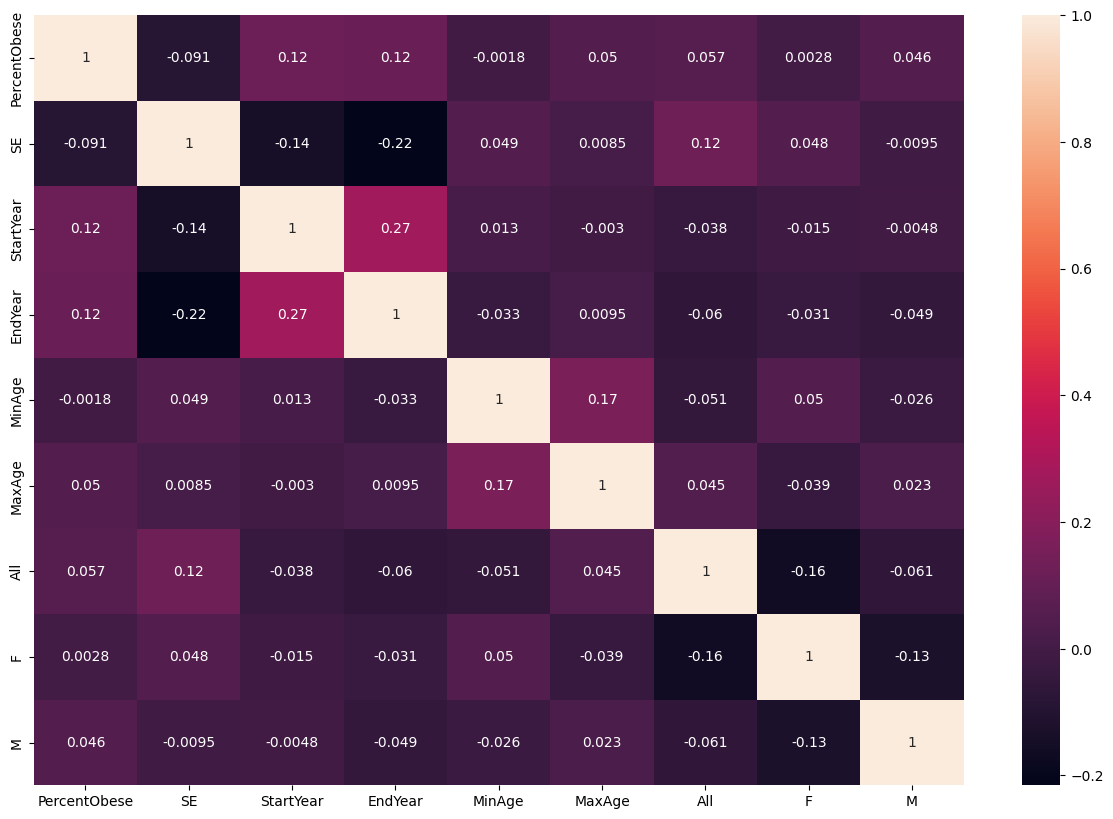

In [26]:
# correlation map
plt.figure(figsize=(15,10))
sns.heatmap(data2.corr(), annot = True)

In [27]:
# model building
X=data2.drop(['PercentObese','SE'],axis=1)
Y=data2['PercentObese']

In [28]:
data2.head()

,PercentObese,SE,StartYear,EndYear,MinAge,MaxAge,All,F,M
0,-1.126733,-0.6,1971,1974,-1.025023,-1.0798,1,0,0
1,-1.126733,-0.6,1976,1980,-1.025023,-1.0798,1,0,0
2,-0.750777,-0.7,1988,1994,-1.025023,-1.0798,1,0,0
3,-0.221020,-1.7,1999,2000,-1.025023,-1.0798,1,0,0
4,-0.169754,-1.8,2001,2002,-1.025023,-1.0798,1,0,0


In [29]:
# splitting dataset into training, testing and validation dataset
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=42)
X_valid, X_test, Y_valid, Y_test = train_test_split(X_train, Y_train, test_size=0.50, random_state=42)
train_data = X_train.join(Y_train)
test_data = X_test.join(Y_test)
Y_test = Y_test[:-1]
X_test = X_test[:-1]
valid_data = X_valid.join(Y_valid)

# Print the sizes of each set
print("Training set size:", len(X_train))
print("Validation set size:", len(X_valid))
print("Testing set size:", len(X_test))

Training set size: 475
Validation set size: 237
Testing set size: 237


In [30]:
scaler = StandardScaler()

# Scale the train set
X_train = scaler.fit_transform(X_train)

# Scale the test set
X_test = scaler.fit_transform(X_test)

# Scale the validation set
X_valid = scaler.fit_transform(X_valid)

array([[<Axes: title={'center': 'StartYear'}>,
        <Axes: title={'center': 'EndYear'}>,
        <Axes: title={'center': 'MinAge'}>],
       [<Axes: title={'center': 'MaxAge'}>,
        <Axes: title={'center': 'All'}>, <Axes: title={'center': 'F'}>],
       [<Axes: title={'center': 'M'}>,
        <Axes: title={'center': 'PercentObese'}>, <Axes: >]], dtype=object)

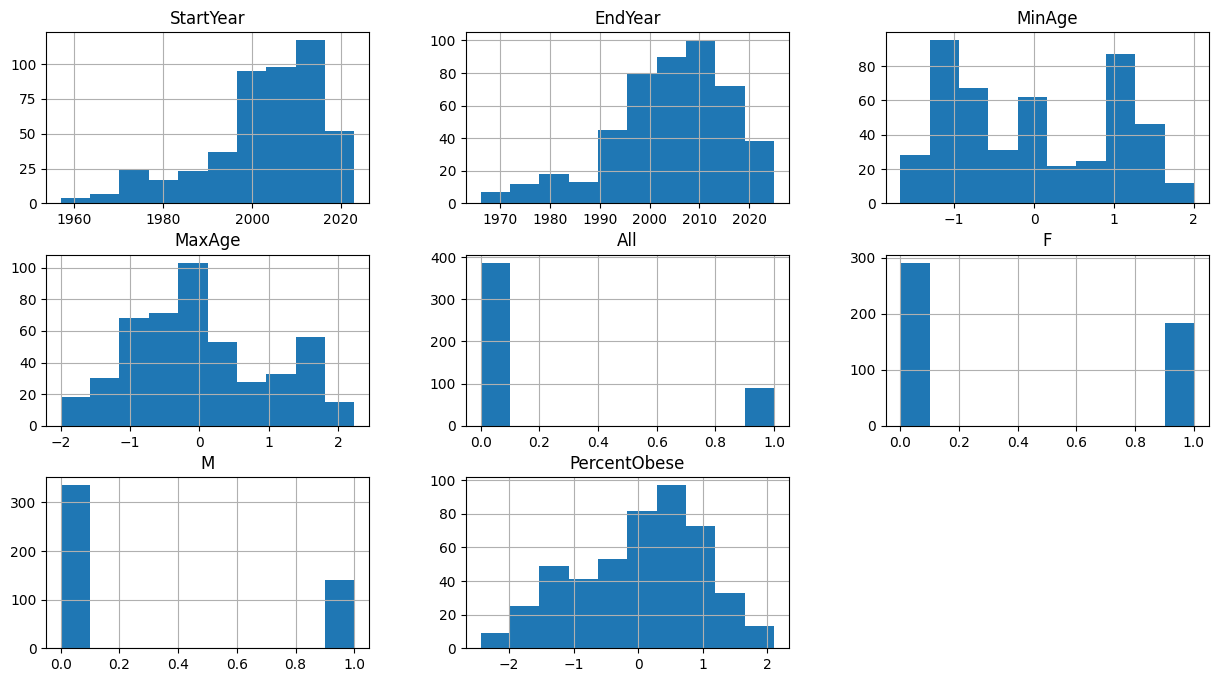

In [31]:
train_data.hist(figsize=(15,8))

In [32]:
# model selection

In [33]:
# linear regression
print("Linear Regression\n")

lr_model = LinearRegression()
lr_model.fit(X_train, Y_train)

# Predict the target values for the validation set
y_pred_lr = lr_model.predict(X_valid)

# Calculate the Mean Squared Error (MSE)
mse_lr = mean_squared_error(Y_valid, y_pred_lr)

# Calculate the R-squared (R2) score
r2_lr = r2_score(Y_valid, y_pred_lr)

print("MSE Value: ", mse_lr , "\n")
print("R^2 Score Value: ", r2_lr)

Linear Regression

MSE Value:  0.9109925341414615 

R^2 Score Value:  0.014598336719236715


In [34]:
# Hidden Markov Model (HMM)
print("Hidden Markov Model\n")
hmm_model = hmm.GaussianHMM(n_components=2)  # Adjust the number of components as needed
hmm_model.fit(X_train)

# Predict the target variable for the validation set using HMM
hmm_y_pred_val = hmm_model.predict(X_valid)

# Calculate mean squared error (MSE) and R-squared (R^2) for HMM
hmm_mse = mean_squared_error(Y_valid, hmm_y_pred_val)
hmm_r2 = r2_score(Y_valid, hmm_y_pred_val)

# Print the results
print("MSE Value: ", hmm_mse, "\n")
print("R^2 Score Value: ", hmm_r2)

Hidden Markov Model

MSE Value:  0.9331830257083837 

R^2 Score Value:  -0.009404656147955492


In [35]:
# Support Vector Regression (SVR)
print("Support Vector Regression\n")
# Create and train the SVM regression model
svr_model = SVR()
svr_model.fit(X_train, Y_train)

# Make predictions on the test set
y_pred_svr = svr_model.predict(X_valid)

# Calculate evaluation metrics
svr_mse = mean_squared_error(Y_valid, y_pred_svr)
svr_r2 = r2_score(Y_valid, y_pred_svr)

print("Mean Squared Error (MSE):", svr_mse,"\n")
print("R^2 Score Value", svr_r2)


Support Vector Regression

Mean Squared Error (MSE): 0.6697966726889052 

R^2 Score Value 0.2754948799338035


In [36]:
# KNN algorithm
print("KNN Algorithm\n")
k = 5  # Number of neighbors
model = KNeighborsRegressor(n_neighbors=k)
model.fit(X_train, Y_train)

y_pred_knn = model.predict(X_valid)

knn_mse = mean_squared_error(Y_valid, y_pred_knn)
knn_r2 = r2_score(Y_valid, y_pred_knn)

print("Mean Squared Error:", knn_mse, "\n")
print("R-squared:", knn_r2)

KNN Algorithm

Mean Squared Error: 0.6952683116050047 

R-squared: 0.24794273827101154


In [37]:
# Random Forest Regression
print("Random Forest Regression\n")
# Create a Random Forest regressor object
modelrf = RandomForestRegressor()

# Train the model
modelrf.fit(X_train, Y_train)

# Make predictions on the test set
predictionsrf = modelrf.predict(X_valid)

# Calculate the RMSE
rf_mse = mean_squared_error(Y_valid, predictionsrf)

# Calculate the R-squared score
rf_r2 = r2_score(Y_valid, predictionsrf)

# Print the RMSE and R-squared score
print("Mean Squared Error (MSE):", rf_mse, "\n")
print("R-squared (R^2) Score:", rf_r2)

Random Forest Regression

Mean Squared Error (MSE): 0.20845494115953725 

R-squared (R^2) Score: 0.7745186288147947


In [38]:
# Gradient Boosting Algorithm
print("Gradient Boosting Algorithm\n")
params = {
    "n_estimators": 500,
    "max_depth": 4,
    "min_samples_split": 5,
    "learning_rate": 0.005,
    "loss": "squared_error",
}
gb_model = GradientBoostingRegressor(**params)
gb_model.fit(X_train, Y_train)

# Predict the target variable for the validation set using Gradient Boosting
gb_y_pred_val = gb_model.predict(X_valid)

# Calculate mean squared error (MSE) and R-squared (R^2) for Gradient Boosting
gb_mse = mean_squared_error(Y_valid, gb_y_pred_val)
gb_r2 = r2_score(Y_valid, gb_y_pred_val)

print("MSE Value: ", gb_mse, "\n")

print("R^2 Score Value: ", gb_r2)

Gradient Boosting Algorithm

MSE Value:  0.6704043225892635 

R^2 Score Value:  0.2748375976838784


In [39]:
# Artificial Neural Network Algorithm
print("Artificial Neural Network Algorithm\n")
# 1st model
#Initialize
model1=Sequential()
# input layer
model1.add(Dense(12,activation='relu', input_shape=(7,)))
# hidden layer
model1.add(Dense(12, activation='relu'))
model1.add(Dense(24, activation='relu'))
model1.add(Dense(36, activation='relu'))
# output layer
model1.add(Dense(1, activation='linear'))

Artificial Neural Network Algorithm



In [40]:
# 2nd model
#Initialize
model2=Sequential()
# input layer
model2.add(Dense(12,activation='relu', input_shape=(7,)))
# hidden layer
model2.add(Dense(36, activation='relu'))
model2.add(Dense(48, activation='relu'))
model2.add(Dense(36, activation='relu'))
# output layer
model2.add(Dense(1, activation='linear'))

In [41]:
# 3rd model
#Initialize
model3=Sequential()
# input layer
model3.add(Dense(12,activation='relu', input_shape=(7,)))
# hidden layer
model3.add(Dense(12, activation='relu'))
model3.add(Dense(24, activation='relu'))
model3.add(Dense(12, activation='relu'))
# output layer
model3.add(Dense(1, activation='linear'))

In [42]:
learning_rate = 0.01
optimizer = Adam(learning_rate=learning_rate)
model1.compile(loss='mean_squared_error', optimizer=optimizer)
histories = []                   
history = model1.fit(X_train, Y_train,epochs=100, batch_size=10, verbose=1, validation_data=(X_valid, Y_valid))
histories.append(history)

Epoch 1/100
48/48 [==============================] - 2s 17ms/step - loss: 0.9675 - val_loss: 0.9192
Epoch 2/100
48/48 [==============================] - 0s 8ms/step - loss: 0.9371 - val_loss: 0.8656
Epoch 3/100
48/48 [==============================] - 0s 5ms/step - loss: 0.9174 - val_loss: 0.8304
Epoch 4/100
48/48 [==============================] - 0s 5ms/step - loss: 0.9212 - val_loss: 0.8814
Epoch 5/100
48/48 [==============================] - 0s 7ms/step - loss: 0.8731 - val_loss: 0.7968
Epoch 6/100
48/48 [==============================] - 0s 8ms/step - loss: 0.8617 - val_loss: 0.8669
Epoch 7/100
48/48 [==============================] - 0s 7ms/step - loss: 0.8440 - val_loss: 0.7887
Epoch 8/100
48/48 [==============================] - 0s 6ms/step - loss: 0.8143 - val_loss: 0.7932
Epoch 9/100
48/48 [==============================] - 0s 6ms/step - loss: 0.8641 - val_loss: 0.8527
Epoch 10/100
48/48 [==============================] - 0s 8ms/step - loss: 0.8172 - val_loss: 0.8105
Epoch 11

In [43]:
learning_rate = 0.01
optimizer = Adam(learning_rate=learning_rate)
model2.compile(loss='mean_squared_error', optimizer=optimizer)
history = model2.fit(X_train, Y_train,epochs=100, batch_size=10, verbose=1, validation_data=(X_valid, Y_valid))
histories.append(history)

Epoch 1/100
48/48 [==============================] - 1s 9ms/step - loss: 0.9691 - val_loss: 0.9174
Epoch 2/100
48/48 [==============================] - 0s 5ms/step - loss: 0.9428 - val_loss: 0.8810
Epoch 3/100
48/48 [==============================] - 0s 5ms/step - loss: 0.9135 - val_loss: 0.8498
Epoch 4/100
48/48 [==============================] - 0s 4ms/step - loss: 0.9099 - val_loss: 0.8573
Epoch 5/100
48/48 [==============================] - 0s 4ms/step - loss: 0.8938 - val_loss: 0.8142
Epoch 6/100
48/48 [==============================] - 0s 4ms/step - loss: 0.8601 - val_loss: 0.8107
Epoch 7/100
48/48 [==============================] - 0s 4ms/step - loss: 0.8450 - val_loss: 0.7759
Epoch 8/100
48/48 [==============================] - 0s 4ms/step - loss: 0.8453 - val_loss: 0.8270
Epoch 9/100
48/48 [==============================] - 0s 6ms/step - loss: 0.8291 - val_loss: 0.7528
Epoch 10/100
48/48 [==============================] - 0s 6ms/step - loss: 0.7697 - val_loss: 0.7649
Epoch 11/

In [44]:
learning_rate = 0.01
optimizer = Adam(learning_rate=learning_rate)
model3.compile(loss='mean_squared_error', optimizer=optimizer)

history = model3.fit(X_train, Y_train,epochs=100, batch_size=10, verbose=1, validation_data=(X_valid, Y_valid))
histories.append(history)

Epoch 1/100
48/48 [==============================] - 3s 18ms/step - loss: 0.9632 - val_loss: 0.9058
Epoch 2/100
48/48 [==============================] - 0s 9ms/step - loss: 0.9362 - val_loss: 0.8783
Epoch 3/100
48/48 [==============================] - 0s 7ms/step - loss: 0.8912 - val_loss: 0.8210
Epoch 4/100
48/48 [==============================] - 1s 12ms/step - loss: 0.8735 - val_loss: 0.8270
Epoch 5/100
48/48 [==============================] - 1s 11ms/step - loss: 0.8488 - val_loss: 0.8195
Epoch 6/100
48/48 [==============================] - 1s 11ms/step - loss: 0.8090 - val_loss: 0.7978
Epoch 7/100
48/48 [==============================] - 0s 7ms/step - loss: 0.8513 - val_loss: 0.7619
Epoch 8/100
48/48 [==============================] - 0s 8ms/step - loss: 0.7813 - val_loss: 0.7910
Epoch 9/100
48/48 [==============================] - 0s 9ms/step - loss: 0.7766 - val_loss: 0.7342
Epoch 10/100
48/48 [==============================] - 0s 5ms/step - loss: 0.7607 - val_loss: 0.7695
Epoch

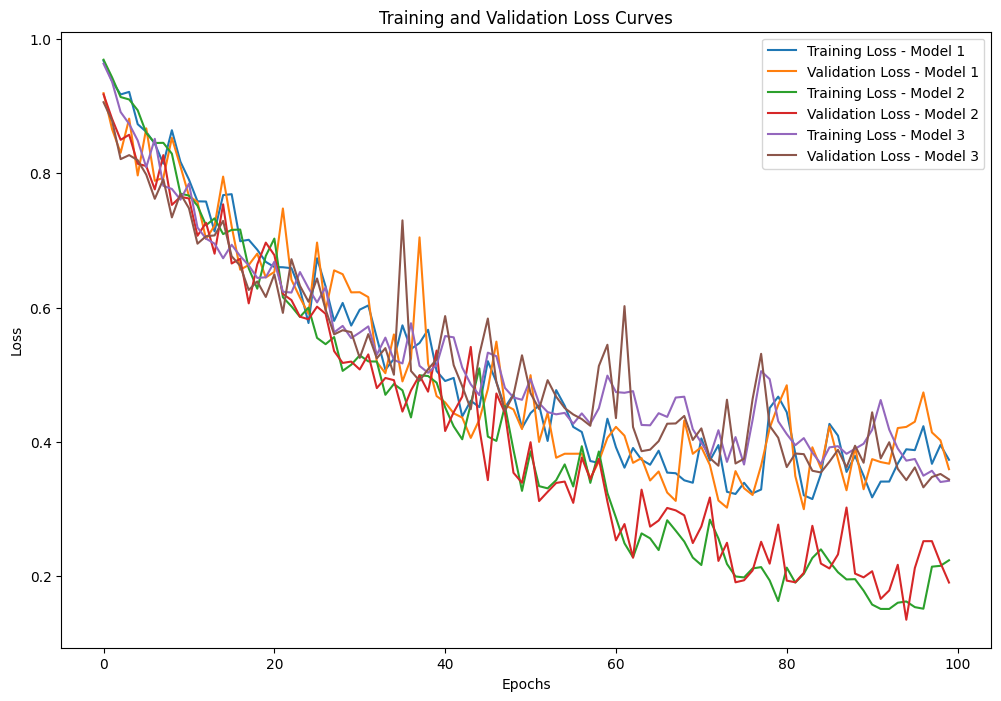

In [45]:
# plotting training and validation loss curves
plt.figure(figsize=(12, 8))
for i, history in enumerate(histories):
    plt.plot(history.history['loss'], label='Training Loss - Model {}'.format(i+1))
    plt.plot(history.history['val_loss'], label='Validation Loss - Model {}'.format(i+1))

plt.title('Training and Validation Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

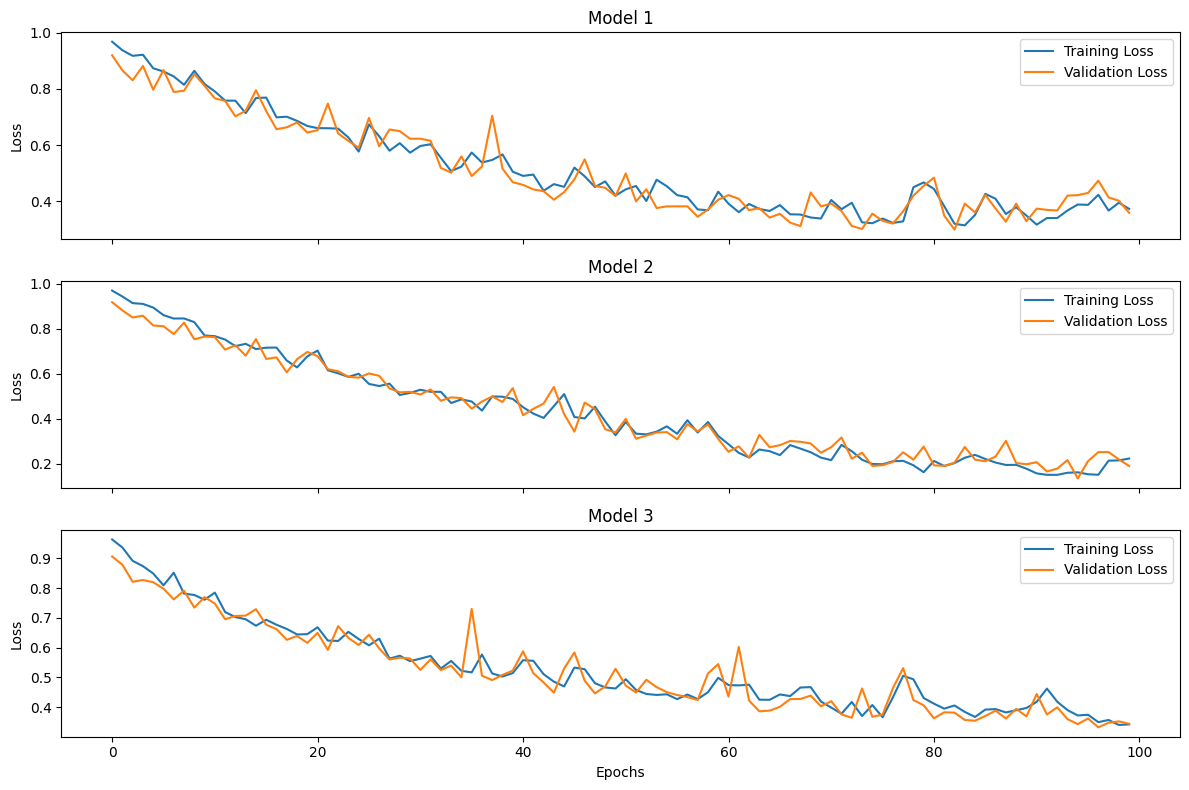

In [46]:
# Check if there is only one model
if len(histories) == 1:
    # Create a single subplot for the model
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.plot(histories[0].history['loss'], label='Training Loss')
    ax.plot(histories[0].history['val_loss'], label='Validation Loss')
    ax.set_title('Model 1')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.legend()
else:
    # Create subplots for each model
    fig, axs = plt.subplots(len(histories), 1, figsize=(12, 8), sharex=True)

    # Plot the loss curves for each model
    for i, history in enumerate(histories):
        axs[i].plot(history.history['loss'], label='Training Loss')
        axs[i].plot(history.history['val_loss'], label='Validation Loss')
        axs[i].set_title('Model {}'.format(i+1))
        axs[i].set_ylabel('Loss')
        axs[i].legend()

    # Set common x-axis label
    axs[-1].set_xlabel('Epochs')

    # Adjust spacing between subplots
    plt.tight_layout()

# Display the plot
plt.show()

In [47]:
# make predictions on the test set
models = [model1, model2, model3]
for i, model in enumerate(models):
    print("Model", i+1)
    # Make predictions on the test set
    Y_pred = model.predict(X_valid)
    # print(y_pred[:10])
    preddf = pd.DataFrame(Y_pred, columns=['Predicted Obesity Level'])
    # Print the DataFrame
    print(preddf.head(10))
    print()

Model 1
8/8 [==============================] - 0s 4ms/step
   Predicted Obesity Level
0                -1.048665
1                -0.464707
2                 0.904358
3                -0.385892
4                 1.103796
5                -0.838469
6                 1.061121
7                -0.343813
8                 0.593398
9                 0.387479

Model 2
8/8 [==============================] - 0s 3ms/step
   Predicted Obesity Level
0                -0.833599
1                -1.072482
2                 0.716847
3                 0.203193
4                 1.060317
5                -0.870793
6                 0.545014
7                -0.863073
8                 0.476627
9                -0.256151

Model 3
8/8 [==============================] - 0s 2ms/step
   Predicted Obesity Level
0                -1.502330
1                -0.166350
2                 0.989575
3                 0.873464
4                 1.107234
5                -0.620793
6                 0.178740
7          

In [48]:
# Model evaluations
models = [model1, model2, model3] 
for i, model in enumerate(models):
    print("Model", i+1)    
    # Perform evaluation on the validation set
    loss = model.evaluate(X_valid, Y_valid)
    # Print the evaluation results
    print("Test Loss:", loss)
    print()

Model 1
8/8 [==============================] - 0s 2ms/step - loss: 0.3592
Test Loss: 0.35923030972480774

Model 2
8/8 [==============================] - 0s 2ms/step - loss: 0.1904
Test Loss: 0.19036626815795898

Model 3
8/8 [==============================] - 0s 1ms/step - loss: 0.3439
Test Loss: 0.3439328670501709



In [49]:
# Model tuning
# model 2 is chosen for ann algorithm

In [50]:
# model tuning
# Define the function to create the model
def create_model(optimizer='adam', learning_rate=0.01):
    model = Sequential()
    model.add(Dense(12, activation='relu', input_shape=(7,)))
    model.add(Dense(36, activation='relu'))
    model.add(Dense(48, activation='relu'))
    model.add(Dense(36, activation='relu'))
    model.add(Dense(1, activation='linear'))
    optimizer = optimizer(learning_rate=learning_rate)
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return model

# Create the KerasRegressor object
bestmodel = KerasRegressor(build_fn=create_model, verbose=0)

# Define the hyperparameters to tune
param_grid = {
    'batch_size': [32, 64],
    'optimizer': [Adam, RMSprop],
    'learning_rate': [0.001, 0.01, 0.1]
}

# Perform grid search with cross-validation
grid = GridSearchCV(estimator=bestmodel, param_grid=param_grid, cv=3)
grid_result = grid.fit(X_train, Y_train)

best_model_ann = grid_result.best_estimator_
best_params_ann = grid_result.best_params_

# Evaluate the best model on the test set
Y_pred_ann = best_model_ann.predict(X_test)
mse_ann_best = mean_squared_error(Y_test, Y_pred_ann)
print("Best Model MSE:", mse_ann_best, "\n")

# Print the best hyperparameters
print("Best Hyperparameters: ", best_params_ann)


C:\Users\HP\AppData\Local\Temp\ipykernel_9684\3432790566.py:15: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  bestmodel = KerasRegressor(build_fn=create_model, verbose=0)


Best Model MSE: 0.9543376692032581 

Best Hyperparameters:  {'batch_size': 64, 'learning_rate': 0.01, 'optimizer': <class 'keras.optimizers.legacy.rmsprop.RMSprop'>}


In [51]:
ann_model = Sequential()
# input layer
ann_model.add(Dense(12,activation='relu', input_shape=(7,)))
# hidden layer
ann_model.add(Dense(36, activation='relu'))
ann_model.add(Dense(48, activation='relu'))
ann_model.add(Dense(36, activation='relu'))
# output layer
ann_model.add(Dense(1, activation='linear'))
learning_rate = 0.01
optimizer = Adam(learning_rate=learning_rate)
ann_model.compile(loss='mean_squared_error', optimizer=optimizer)
results_ann = ann_model.fit(X_train, Y_train,epochs=100, batch_size=64, verbose=1, validation_data=(X_valid, Y_valid))

Epoch 1/100
8/8 [==============================] - 1s 55ms/step - loss: 0.9564 - val_loss: 0.9034
Epoch 2/100
8/8 [==============================] - 0s 19ms/step - loss: 0.8879 - val_loss: 0.8400
Epoch 3/100
8/8 [==============================] - 0s 10ms/step - loss: 0.8496 - val_loss: 0.8061
Epoch 4/100
8/8 [==============================] - 0s 13ms/step - loss: 0.8196 - val_loss: 0.7801
Epoch 5/100
8/8 [==============================] - 0s 13ms/step - loss: 0.7899 - val_loss: 0.7797
Epoch 6/100
8/8 [==============================] - 0s 12ms/step - loss: 0.7781 - val_loss: 0.7327
Epoch 7/100
8/8 [==============================] - 0s 13ms/step - loss: 0.7253 - val_loss: 0.6800
Epoch 8/100
8/8 [==============================] - 0s 12ms/step - loss: 0.6900 - val_loss: 0.6654
Epoch 9/100
8/8 [==============================] - 0s 13ms/step - loss: 0.6785 - val_loss: 0.7113
Epoch 10/100
8/8 [==============================] - 0s 13ms/step - loss: 0.7159 - val_loss: 0.6503
Epoch 11/100
8/8 [=

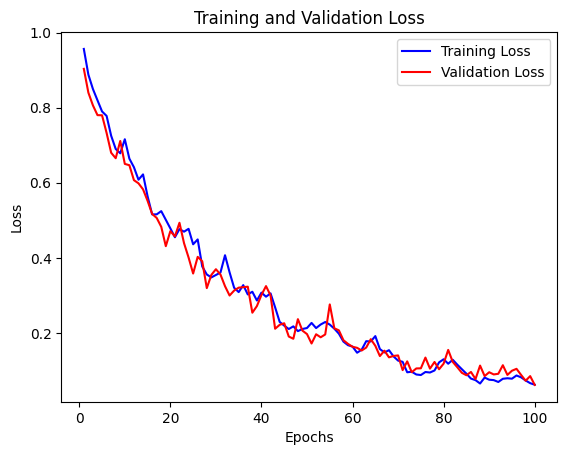

In [52]:
# Get the training and validation loss from the history object
train_loss = results_ann.history['loss']
val_loss = results_ann.history['val_loss']

# Create a list of epochs
epochs = range(1, len(train_loss) + 1)

# Plot the training and validation loss curves
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [53]:
# Evaluate the model on the test set
test_loss = ann_model.evaluate(X_test, Y_test)

# Print the test loss
print("Test Loss:", test_loss)


8/8 [==============================] - 0s 3ms/step - loss: 0.1180
Test Loss: 0.11798478662967682


In [54]:
# ann algorithm
# Make predictions on the test set
predictionsann = ann_model.predict(X_test)

# Calculate the RMSE
ann_mse = mean_squared_error(Y_test, predictionsann)

# Calculate the R-squared score
ann_r2 = r2_score(Y_test, predictionsann)

# Print the RMSE and R-squared score
print("\nRoot Mean Squared Error (RMSE):", ann_mse, "\n")
print("R-squared (R^2) Score:", ann_r2)


8/8 [==============================] - 0s 3ms/step

Root Mean Squared Error (RMSE): 0.11798478688356426 

R-squared (R^2) Score: 0.8778459842925107


In [55]:
print("Artificial Neural Network")
# Convert Y_test to a numpy array and flatten it
actual_values = Y_test.values.flatten()
# Print the predictions versus the actual values
df_predictionsann = pd.DataFrame({'Predictions': predictionsann.flatten(), 'Actual': actual_values})
df_predictionsann['Error'] = df_predictionsann['Actual'] - df_predictionsann['Predictions']
df_predictionsann.head(10)

Artificial Neural Network


,Predictions,Actual,Error
0,0.595591,0.834985,0.239393
1,0.781554,0.407183,-0.374371
2,0.998484,1.018681,0.020197
3,-1.041128,-0.631761,0.409367
4,-0.193745,0.342562,0.536307
5,-0.961560,-0.938755,0.022805
6,0.656032,0.631474,-0.024558
7,0.546665,0.568590,0.021925
8,-1.060183,-1.224724,-0.164540
9,-0.663743,-0.482859,0.180885


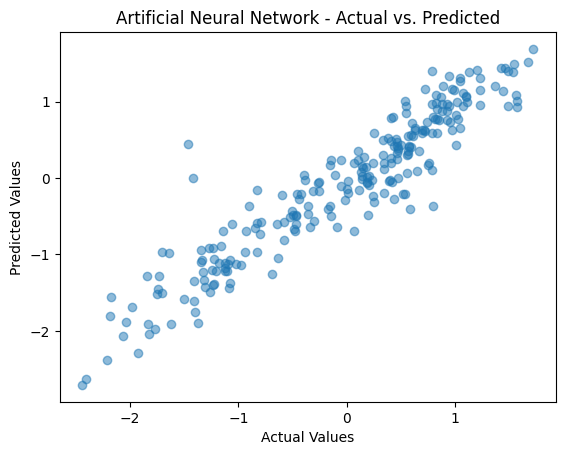

In [56]:
# Visualize scatter graph
plt.scatter(Y_test, predictionsann, alpha=0.5)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Artificial Neural Network - Actual vs. Predicted')
plt.show()

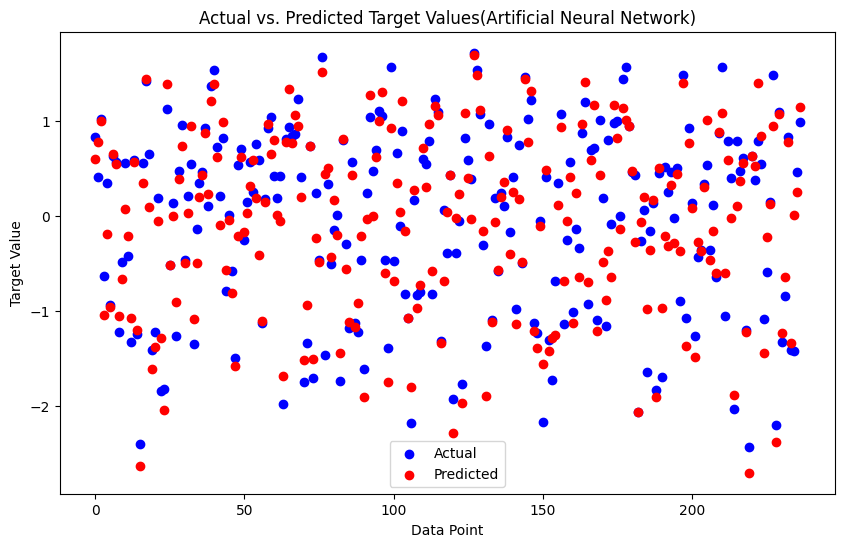

In [57]:
import matplotlib.pyplot as plt

# Plotting the predicted and actual target values
plt.figure(figsize=(10, 6))
plt.scatter(range(len(Y_test)), Y_test, color='blue', label='Actual')
plt.scatter(range(len(Y_test)), predictionsann.flatten(), color='red', label='Predicted')
plt.xlabel('Data Point')
plt.ylabel('Target Value')
plt.title('Actual vs. Predicted Target Values(Artificial Neural Network)')
plt.legend()
plt.show()

In [58]:
# Random Forest Regression
print("Random Forest Regression\n")

# Create a Random Forest regressor object
model_rf = RandomForestRegressor()

# Train the model
model_rf.fit(X_train, Y_train)

# Make predictions on the test set
pred_rf = model_rf.predict(X_test)

# Calculate the RMSE
rf_mse_test = mean_squared_error(Y_test, pred_rf)

# Calculate the R-squared score
rf_r2_test = r2_score(Y_test, pred_rf)

# Print the RMSE and R-squared score
print("Mean Squared Error (MSE):", rf_mse_test, "\n")
print("R-squared (R^2) Score:", rf_r2_test)

Random Forest Regression

Mean Squared Error (MSE): 0.21402913702066675 

R-squared (R^2) Score: 0.7784077146210031


In [59]:
# Create DataFrame with Actual and Predicted values
results_dfrf = pd.DataFrame({'Actual': Y_test, 'Predicted': pred_rf})

# Calculate the error
results_dfrf['Error'] = results_dfrf['Actual'] - results_dfrf['Predicted']

# Print the DataFrame
results_dfrf.head(10)

,Actual,Predicted,Error
417,0.834985,0.436628,0.398357
205,0.407183,0.418901,-0.011718
247,1.018681,0.941535,0.077146
457,-0.631761,-0.447620,-0.184141
217,0.342562,0.311212,0.031350
22,-0.938755,-0.790212,-0.148543
462,0.631474,0.450138,0.181336
243,0.568590,0.432363,0.136227
420,-1.224724,-0.698296,-0.526427
203,-0.482859,-0.125501,-0.357358


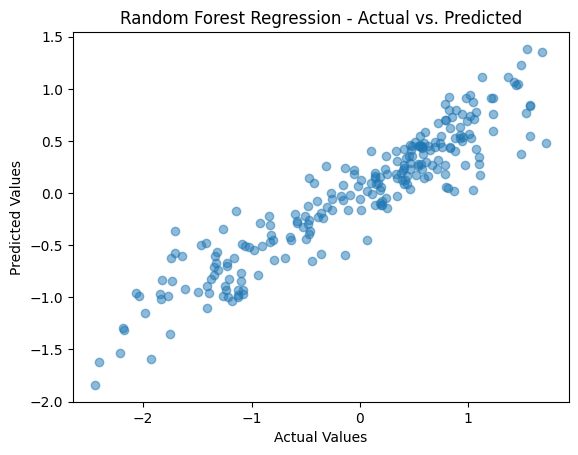

In [60]:
# Visualize scatter graph
plt.scatter(Y_test, pred_rf, alpha=0.5)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Random Forest Regression - Actual vs. Predicted')
plt.show()

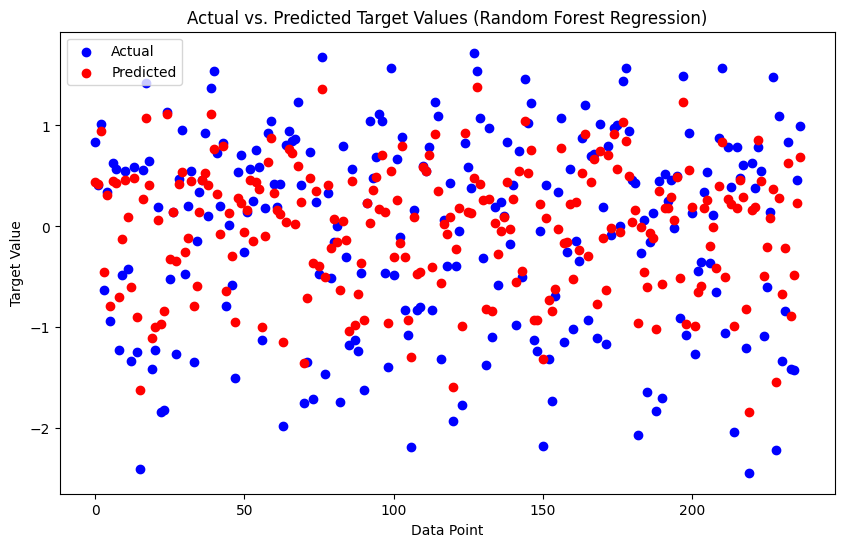

In [61]:
# Plotting the predicted and actual target values
plt.figure(figsize=(10, 6))
plt.scatter(range(len(Y_test)), Y_test, color='blue', label='Actual')
plt.scatter(range(len(Y_test)), pred_rf, color='red', label='Predicted')
plt.xlabel('Data Point')
plt.ylabel('Target Value')
plt.title('Actual vs. Predicted Target Values (Random Forest Regression)')
plt.legend()
plt.show()

In [62]:
# optimising hyperparameters for gradient boosting model
gb = GradientBoostingRegressor()

# Define the parameter grid for GridSearchCV
param_grid = {
    "n_estimators": [100, 200, 500],
    "learning_rate": [0.005, 0.1, 0.05],
    "max_depth": [3, 4, 5],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
}

# Define the scoring metric
scoring_gb = make_scorer(mean_squared_error, greater_is_better=False)

# Create the GridSearchCV object
grid_search_gb = GridSearchCV(estimator=gb, param_grid=param_grid, scoring=scoring_gb, cv=5)

# Fit the GridSearchCV object to the training data
grid_search_gb.fit(X_train, Y_train)

# Get the best model and its hyperparameters
best_model_gb = grid_search_gb.best_estimator_
best_params_gb = grid_search_gb.best_params_

# Evaluate the best model on the test set
y_predgb = best_model_gb.predict(X_test)
msegb = mean_squared_error(Y_test, y_predgb)
print("Best Model MSE:", msegb, "\n")
print("Best Hyperparameters:", best_params_gb)


Best Model MSE: 0.6863888779363256 

Best Hyperparameters: {'learning_rate': 0.005, 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


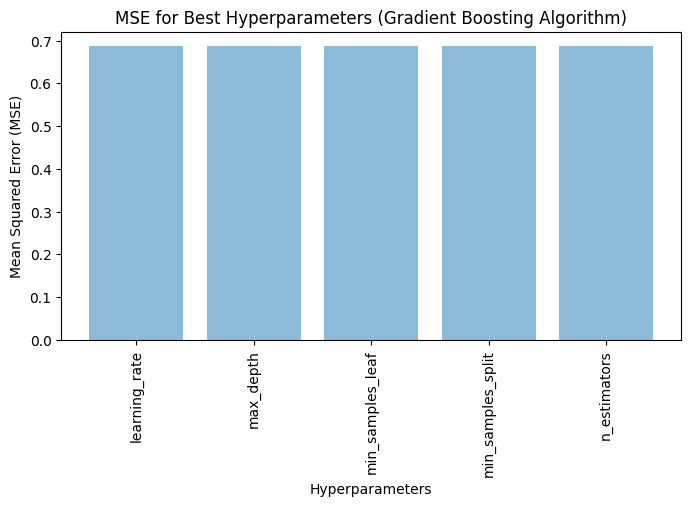

In [63]:
# Plotting the mean squared error (MSE)
plt.figure(figsize=(8, 4))
plt.bar(range(len(best_params_gb)), msegb, align='center', alpha=0.5)
plt.xticks(range(len(best_params_gb)), best_params_gb.keys(), rotation='vertical')
plt.xlabel('Hyperparameters')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('MSE for Best Hyperparameters (Gradient Boosting Algorithm)')
plt.show()

In [64]:
# Gradient Boosting Algorithm
print("Gradient Boosting Algorithm\n")

gb_model_test = GradientBoostingRegressor(**best_params_gb)
gb_model_test.fit(X_train, Y_train)

# Predict the target variable for the validation set using Gradient Boosting
gb_y_pred = gb_model_test.predict(X_test)

# Calculate mean squared error (MSE) and R-squared (R^2) for Gradient Boosting
gb_mse_test = mean_squared_error(Y_test, gb_y_pred)
gb_r2_test = r2_score(Y_test, gb_y_pred)

print("MSE Value: ", gb_mse_test, "\n")

print("R^2 Score Value: ", gb_r2_test)

Gradient Boosting Algorithm

MSE Value:  0.6873661408780655 

R^2 Score Value:  0.2883443994141578


In [65]:
measures = pd.DataFrame({'Actual': Y_test, 'Predicted': gb_y_pred})
measures['Error'] = measures['Actual'] - measures['Predicted']
measures.head(10)

,Actual,Predicted,Error
417,0.834985,0.179261,0.655724
205,0.407183,-0.019687,0.426870
247,1.018681,0.430725,0.587956
457,-0.631761,-0.057052,-0.574709
217,0.342562,0.148048,0.194514
22,-0.938755,-0.623167,-0.315588
462,0.631474,0.116702,0.514771
243,0.568590,0.100833,0.467757
420,-1.224724,-0.160756,-1.063968
203,-0.482859,-0.106792,-0.376067


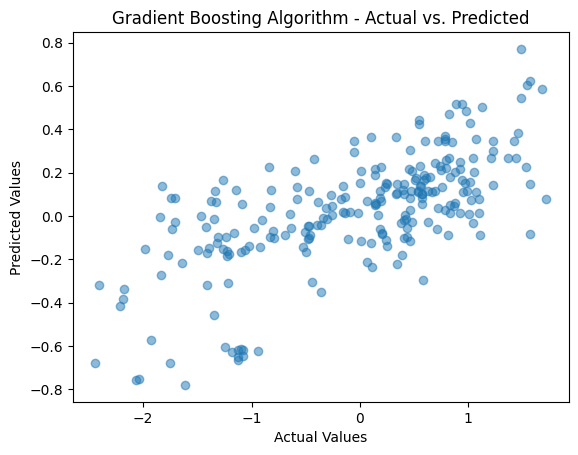

In [66]:
# Visualize scatter graph
plt.scatter(Y_test, gb_y_pred, alpha=0.5)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Gradient Boosting Algorithm - Actual vs. Predicted')
plt.show()

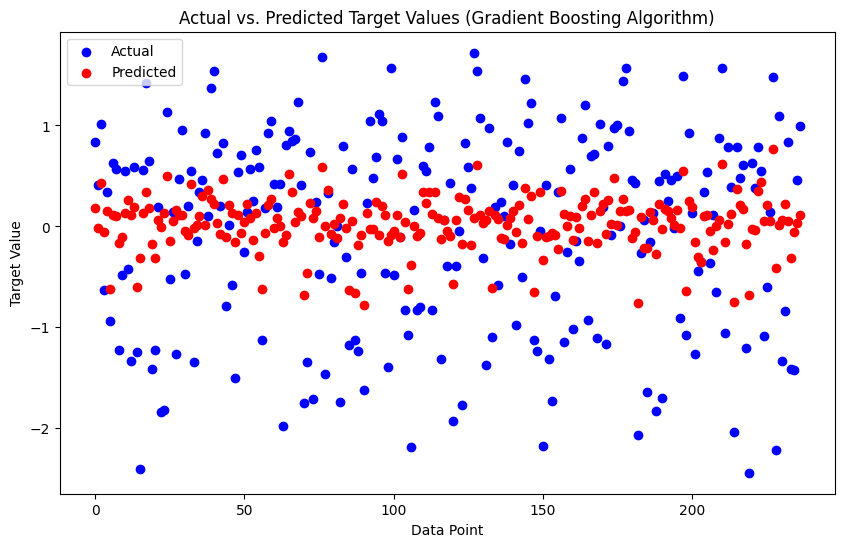

In [67]:
# Plotting the predicted and actual target values
plt.figure(figsize=(10, 6))
plt.scatter(range(len(Y_test)), Y_test, color='blue', label='Actual')
plt.scatter(range(len(Y_test)), gb_y_pred, color='red', label='Predicted')
plt.xlabel('Data Point')
plt.ylabel('Target Value')
plt.title('Actual vs. Predicted Target Values (Gradient Boosting Algorithm)')
plt.legend()
plt.show()

In [68]:
class StackedEnsemble(BaseEstimator, RegressorMixin):
    def __init__(self, base_models, meta_model):
        self.base_models = base_models
        self.meta_model = meta_model
    
    def fit(self, X, y):
        for model in self.base_models:
            model.fit(X, y)
        
        predictions = []
        for model in self.base_models:
            predictions.append(model.predict(X))
        self.meta_model.fit(np.column_stack(predictions), y)
        
        return self
    
    def predict(self, X):
        predictions = []
        for model in self.base_models:
            predictions.append(model.predict(X))
        return self.meta_model.predict(np.column_stack(predictions))

In [69]:
# Create the stacking ensemble model
stacking_model = StackedEnsemble(base_models=[gb_model_test, ann_model, model_rf], meta_model=LinearRegression())

# Fit the stacking ensemble model to the training data
stacking_model.fit(X_train, Y_train)

# Evaluate the stacking ensemble model on the test set
y_pred_ens = stacking_model.predict(X_test)
mse_ens = mean_squared_error(Y_test, y_pred_ens)
r2_ens = r2_score(Y_test, y_pred_ens)
print("\nStacking Ensemble MSE: ", mse_ens,"\n")
print("Stacking Ensemble R-Squared: ", r2_ens)

8/8 [==============================] - 0s 2ms/step

Stacking Ensemble MSE:  0.1049508124471797 

Stacking Ensemble R-Squared:  0.8913405403288273


In [70]:
measures_ens = pd.DataFrame({'Actual': Y_test, 'Predicted': y_pred_ens})
measures_ens['Error'] = measures_ens['Actual'] - measures_ens['Predicted']
measures_ens.head(10)

,Actual,Predicted,Error
417,0.834985,0.698325,0.136660
205,0.407183,0.710571,-0.303388
247,1.018681,1.218356,-0.199675
457,-0.631761,-0.759994,0.128233
217,0.342562,0.223643,0.118919
22,-0.938755,-0.790942,-0.147813
462,0.631474,0.629275,0.002198
243,0.568590,0.667746,-0.099156
420,-1.224724,-0.987691,-0.237032
203,-0.482859,-0.405564,-0.077295


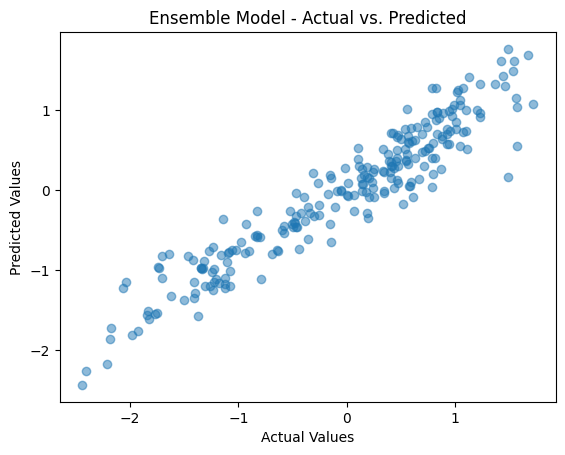

In [71]:
# Visualize scatter graph
plt.scatter(Y_test, y_pred_ens, alpha=0.5)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Ensemble Model - Actual vs. Predicted')
plt.show()

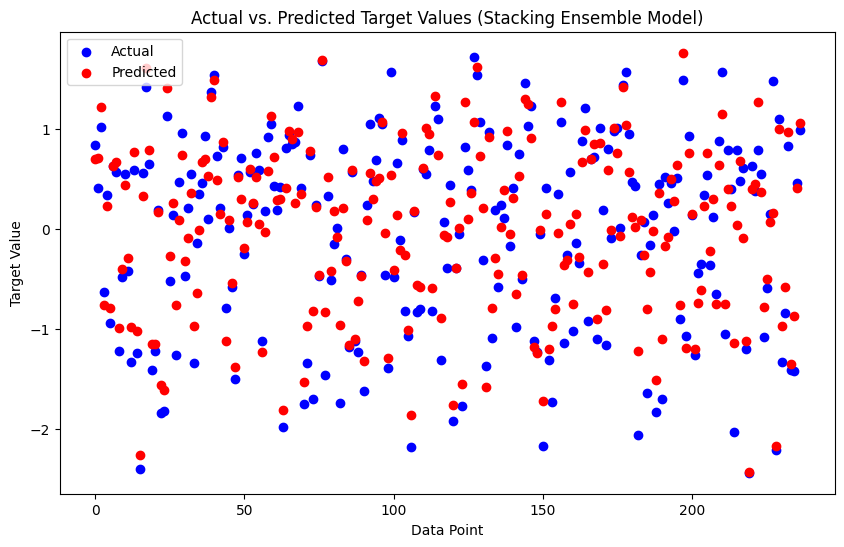

In [72]:
# Plotting the predicted and actual target values
plt.figure(figsize=(10, 6))
plt.scatter(range(len(Y_test)), Y_test, color='blue', label='Actual')
plt.scatter(range(len(Y_test)), y_pred_ens, color='red', label='Predicted')
plt.xlabel('Data Point')
plt.ylabel('Target Value')
plt.title('Actual vs. Predicted Target Values (Stacking Ensemble Model)')
plt.legend()
plt.show()